### EDA-0 

## О задании

В этом задании вы получите опыт подготовки данных и EDA (Exploratory Data Analysis), приблизившись к реальной работе с данными с помощью уже знакомых вам инструментов: numpy, pandas, matplotlib и seaborn, а также познакомитесь с plotly.

EDA - важный этап работы с данными. Именно в процессе EDA вы можете выяснить особенности датасета, найти зависимости в данных, протестировать гипотезы о взаимосвязях признаков и целевой переменной. В реальности вы сами будете определять, что и как проверять в рамках EDA, однако в данной работе гипотезы будут выдвинуты за вас автором задания. Также и типы графиков, которые вы будете использовать уже предопределены за вас. Выполняя задания по визуализациям, обращайте внимание на референсные картинки, которые были оставлены автором. Они показывают, какой примерно результат от вас ожидается.

Это задание будет включать в себя построение некоторого количества графиков, потому вот основные правила, в соответствии с которыми графики должны быть оформлены:
1. Любой график всегда имеет название.
2. Оси у графика подписаны (исключение - график делит название оси с соседним).
3. Подписи делаются на одном языке (либо английский, либо русский), но не на их смеси.
4. Если вы выводите несколько графиков, то они размещаются в рамках одного объекта matplotlib.pyplot.figure. Вы не выводите графики последовательно, а смотрите, как их разместить сразу все за раз.
5. Отдельные графики (если графиков на картинке больше 1) также имеют свои названия.
6. Если на графике есть несколько различных объектов, то для их различения используется легенда. Помещайте легенду в место, где она в наименьшей мере мешает восприятию самого графика.
7. Если есть легенда, то она должна иметь навание, а также ее содержание должно быть адекватными (пожалейте проверяющих, они не хотят разбирать, а к чему относится зеленая линия, которая на легенде помечена меткой "0").
8. Используйте цветовые гаммы, чтобы объекты на графиках отличались цветом.
9. Текст на визуализации должен быть читаем. Если вы вывели названия категорий в качестве подписей на оси Х, а эти названия наезжают друг на друга, то вам нужно что-то с этим сделать. Нечитаемый или плохо читаемый (очень маленький, невероятно огромный) текст ведет к снижению баллов.



## О данных

Будем работать с [датасетом физической активности](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones). 

В этом датасете собраны данные 30 человек, выполняющих различные действия со смартфоном на поясе. Данные записывались с помощью датчиков (акселерометра и гироскопа) в этом смартфоне. Были зафиксированы: "3-осевое линейное ускорение" (_tAcc-XYZ_) и "3-осевая угловая скорость" (_tGyro-XYZ_).

1. Все сигналы отсортированы по времени, пропущены через фильтр шума.
2. Все наблюдения были разделены на окна по 128 сигналов в каждом, причем окна пересекаются на 50% (грубо говоря, с 1 по 128 сигнал в 1 окно, с 64 до 192 сигнала - во 2 окно и так далее).
3. Линейное ускорение было разделено на две составляющие (с помощью низкочастотного фильтра): ускорение самого тела, а также гравитационная составляющая. Будем называть их ускорением тела и гравитационным ускорением.
4. К получившимся окнам применяли различные функции для получения следующих показателей:
    - max
    - min
    - mad (median)
    - mean
    - std
    - skewness (коэффициент асимметричности распределения признака в окне)
    - etc. (подробнее, на сколько это возможно, указано на [страничке датасета](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones))
5. Величина (magnitude) сигнала также определялась через евклидову норму всех значений из вектора для одного окна.
6. К окнам было применено преобразование Фурье, чтобы получить частоты. Из частот были извелченыте же показатели, плюс новые:
    - bandsEnergy (энергия частотного интервала)
7. Были посчитаны углы между векторами соответствующих окон.
8. Для ускорений были посчитаны производные - рывки, к которым применялись те же функции.

Итог: в датасете каждый признак - это какая-то операция над вектором из 128 чисел, которые соответствуют замерам определенного человека занятого какой-то активностью на протяжении 2.56 секунд.

Как читать названия признаков? Примеры:
- `tBodyAccMag-mean()` - это вектор ускорений тела (без гравитационной составляющей этого ускорения), из которого взяли евклидову норму, а затем усреднили, чтобы получить скаляр
- `fBodyAcc-bandsEnergy()-1,8.2` - это вектор ускорения тела, к которому применили преобразование Фурье, преобразовав его в вектор частот, а затем посчитали на этом векторе энергию данного частотного интервала в определенном диапазоне частот (в данном случае 1 - 8.2)
- `angle(X,gravityMean)` - это угол между осью Х и вектором усредненных значений гравитационного ускорения из соответствующего окна

Вероятно, сначала покажется сложным, но мы разберемся с некоторыми признаками в отдельности и вы сможете понять их смысл, уже исходя из фактических соотношений.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [3]:
train.shape

(7352, 563)

В датасете 563 признака, включая целевую переменную. Столько признаков нам не нужно. Мы за вас сделали подвыборку признаков для удобства работы с ними.

In [4]:
cols_subset = [
    'tBodyAccMag-mean()',  # усредненная величина ускорения тела
    'tBodyGyroJerk-mad()-X',  # медианная величина рывка тела по оси Х
    'tGravityAcc-min()-X',  # минимум гравитационной составляющей ускорения по оси Х
    'tBodyAcc-max()-X',  # максимальная величина ускорения тела по оси Х
    'fBodyAcc-bandsEnergy()-1,8.2',  # энергия ускорения тела в интервале частоты
    'angle(X,gravityMean)',  # угол между осью Х и усредненной гравитационной составляющей ускорения
    'angle(Y,gravityMean)',  # угол между осью Y и усредненной гравитационной составляющей ускорения
    'angle(Z,gravityMean)',  # угол между осью Z и усредненной гравитационной составляющей ускорения,
    'fBodyAcc-skewness()-X',  # асимметричность частоты ускорения тела по оси Х
    'subject',  # номер испытуемого
    'Activity',  # название вида деятельности (целевая переменная)
]

In [5]:
train = train[cols_subset]
test = test[cols_subset]

### Задание 1 
Посмотрите на пропуски и дубли в данных train и test. Есть ли они? Если есть, напишите, с чем это может быть связано? Если нет, то просто напишите, что пропусков и/или дублей нет.

In [6]:
# Проверка пропусков в данных train и test
print("Пропуски в train:")
print(train.isnull().sum())

print("\nПропуски в test:")
print(test.isnull().sum())

# Проверка дублей в данных train и test
print("\nКоличество дублей в train:")
print(train.duplicated().sum())

print("\nКоличество дублей в test:")
print(test.duplicated().sum())


Пропуски в train:
tBodyAccMag-mean()              0
tBodyGyroJerk-mad()-X           0
tGravityAcc-min()-X             0
tBodyAcc-max()-X                0
fBodyAcc-bandsEnergy()-1,8.2    0
angle(X,gravityMean)            0
angle(Y,gravityMean)            0
angle(Z,gravityMean)            0
fBodyAcc-skewness()-X           0
subject                         0
Activity                        0
dtype: int64

Пропуски в test:
tBodyAccMag-mean()              0
tBodyGyroJerk-mad()-X           0
tGravityAcc-min()-X             0
tBodyAcc-max()-X                0
fBodyAcc-bandsEnergy()-1,8.2    0
angle(X,gravityMean)            0
angle(Y,gravityMean)            0
angle(Z,gravityMean)            0
fBodyAcc-skewness()-X           0
subject                         0
Activity                        0
dtype: int64

Количество дублей в train:
0

Количество дублей в test:
0


### Задание 2 

Выведите основные статистики данных: среднее, медиана, перцентили (0.25, 0.5, 0.75), минимум, максимум, стандартное отклонение. Посмотрите на таблицу и напишите, видите ли вы в ней что-нибудь интересное.

In [7]:
# Вывод основных статистик для train
print("Статистики для train:")
print(train.describe())

# Вывод основных статистик для test
print("\nСтатистики для test:")
print(test.describe())

Статистики для train:
       tBodyAccMag-mean()  tBodyGyroJerk-mad()-X  tGravityAcc-min()-X  \
count         7352.000000            7352.000000          7352.000000   
mean            -0.543884              -0.727735             0.678505   
std              0.477653               0.315832             0.508656   
min             -1.000000              -0.999889            -1.000000   
25%             -0.983282              -0.991595             0.804270   
50%             -0.883371              -0.950268             0.926693   
75%             -0.106892              -0.474625             0.965095   
max              1.000000               1.000000             1.000000   

       tBodyAcc-max()-X  fBodyAcc-bandsEnergy()-1,8.2  angle(X,gravityMean)  \
count       7352.000000                   7352.000000           7352.000000   
mean          -0.468604                     -0.847963             -0.489547   
std            0.544547                      0.233633              0.511807   
min 

### Задание 3

Данные сбалансированы? У вас есть 6 категорий активности (целевая переменная). Если одна из категорий представлена большим количеством наблюдений, а остальные - нет, то это обстоятельство, о котором хотелось бы знать заранее. Гиперболизированный пример: представьте, что у вас 1000 наблюдений, разделенных на два класса, и только 5 принадлежат ко второму классу. Как учить модель на такой выборке? Есть сильное подозрение, что многие модели будут склонны вырождаться в константу. Отсюда и необходимость проверять баланс классов.

Выведите количество наблюдений для всех категорий активности в train и test. Посчитайте разницу в процентах между самой крупной категорией и самой маленькой (самая большая категория - это 100%). Если разница (округленная до ближайшего целого числа) не превышает 30%, то давайте для наших целей считать, что данные сбалансированы. Напишите, сбалансированы ли данные в train и test.

In [8]:
# Посчитать количество наблюдений для каждой категории активности
train_counts = train['Activity'].value_counts()
test_counts = test['Activity'].value_counts()

# Вычислить разницу в процентах
train_diff = (1 - train_counts.min() / train_counts.max()) * 100
test_diff = (1 - test_counts.min() / test_counts.max()) * 100

# Вывод информации
print("Количество наблюдений для каждой категории в train:")
print(train_counts)
print(f"\nРазница между самой крупной и самой маленькой категорией в train: {train_diff:.2f}%")

print("\nКоличество наблюдений для каждой категории в test:")
print(test_counts)
print(f"\nРазница между самой крупной и самой маленькой категорией в test: {test_diff:.2f}%")

# Проверка сбалансированности
train_balanced = train_diff <= 30
test_balanced = test_diff <= 30

print("\nСбалансированы ли данные?")
print(f"Train: {'Да' if train_balanced else 'Нет'}")
print(f"Test: {'Да' if test_balanced else 'Нет'}")


Количество наблюдений для каждой категории в train:
Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

Разница между самой крупной и самой маленькой категорией в train: 29.92%

Количество наблюдений для каждой категории в test:
Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64

Разница между самой крупной и самой маленькой категорией в test: 21.79%

Сбалансированы ли данные?
Train: Да
Test: Да


### Задание 4

Посчитайте корреляции всех признаков (включая таргет) со всеми другими. Какими получились значения? Есть идеи, почему так? Напишите ваши мысли.

In [9]:
# Исключаем нечисловые столбцы (например, 'Activity') из расчета корреляций
correlation_matrix = train.select_dtypes(include=[float, int]).corr()
# Выводим матрицу корреляций
print(correlation_matrix)

                              tBodyAccMag-mean()  tBodyGyroJerk-mad()-X  \
tBodyAccMag-mean()                      1.000000               0.899080   
tBodyGyroJerk-mad()-X                   0.899080               1.000000   
tGravityAcc-min()-X                     0.369962               0.380118   
tBodyAcc-max()-X                        0.959827               0.879900   
fBodyAcc-bandsEnergy()-1,8.2            0.697832               0.507939   
angle(X,gravityMean)                   -0.370849              -0.382246   
angle(Y,gravityMean)                    0.495561               0.478567   
angle(Z,gravityMean)                    0.426283               0.380967   
fBodyAcc-skewness()-X                   0.379796               0.266002   
subject                                -0.073652              -0.110321   

                              tGravityAcc-min()-X  tBodyAcc-max()-X  \
tBodyAccMag-mean()                       0.369962          0.959827   
tBodyGyroJerk-mad()-X           

Поздравляем! Вы предобработали данные для максимально комфортного их последующего анализа. Теперь вы готовы приступить к Exploratory Data Analysis!

## Exploratory Data Analysis

### Задание 5 

Вы проверили основную информацию о данных и составили свое первое впечатление о них. Теперь визуализации.

Начнем рисовать графики с небольшой разминки. Выберите две любые математические функции (отличные от линейной) и нарисуйте их на одном графике. Подпишите каждый из графиков, чтобы было понятно, какие функции вы выбрали. Ниже будет пример.

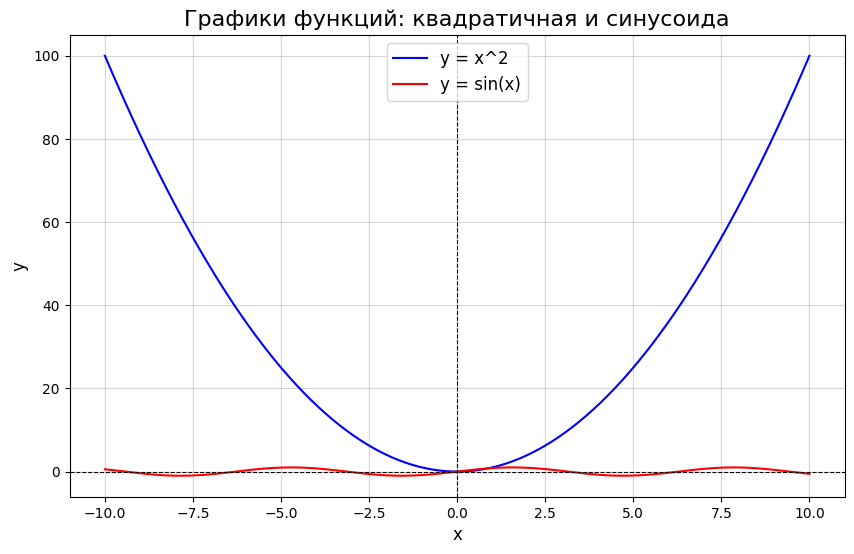

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Создаем значения x
x = np.linspace(-10, 10, 500)

# Определяем функции
y1 = x**2  # Квадратичная функция
y2 = np.sin(x)  # Синусоида

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label="y = x^2", color="blue")  # График квадратичной функции
plt.plot(x, y2, label="y = sin(x)", color="red")  # График синусоиды

# Настраиваем оформление
plt.title("Графики функций: квадратичная и синусоида", fontsize=16)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()

### Задание 6 
Ранее мы уже проверили сбалансированность данных по разным категориям активностей в train и test сетах. Теперь визуализируйте количество сэмплов в каждой из категорий отдельно для train и test сетов, как в примере ниже. Проследите, чтобы порядок категорий слева и справа был одинаков. Иначе не очень удобно их сравнивать (когда они в разных местах двух графиков). Также заметьте, что в примере ось Х в одинаковом масштабе, что тоже удобно для сравнения.

Вам может пригодиться:
- plt.barh или ax.barh

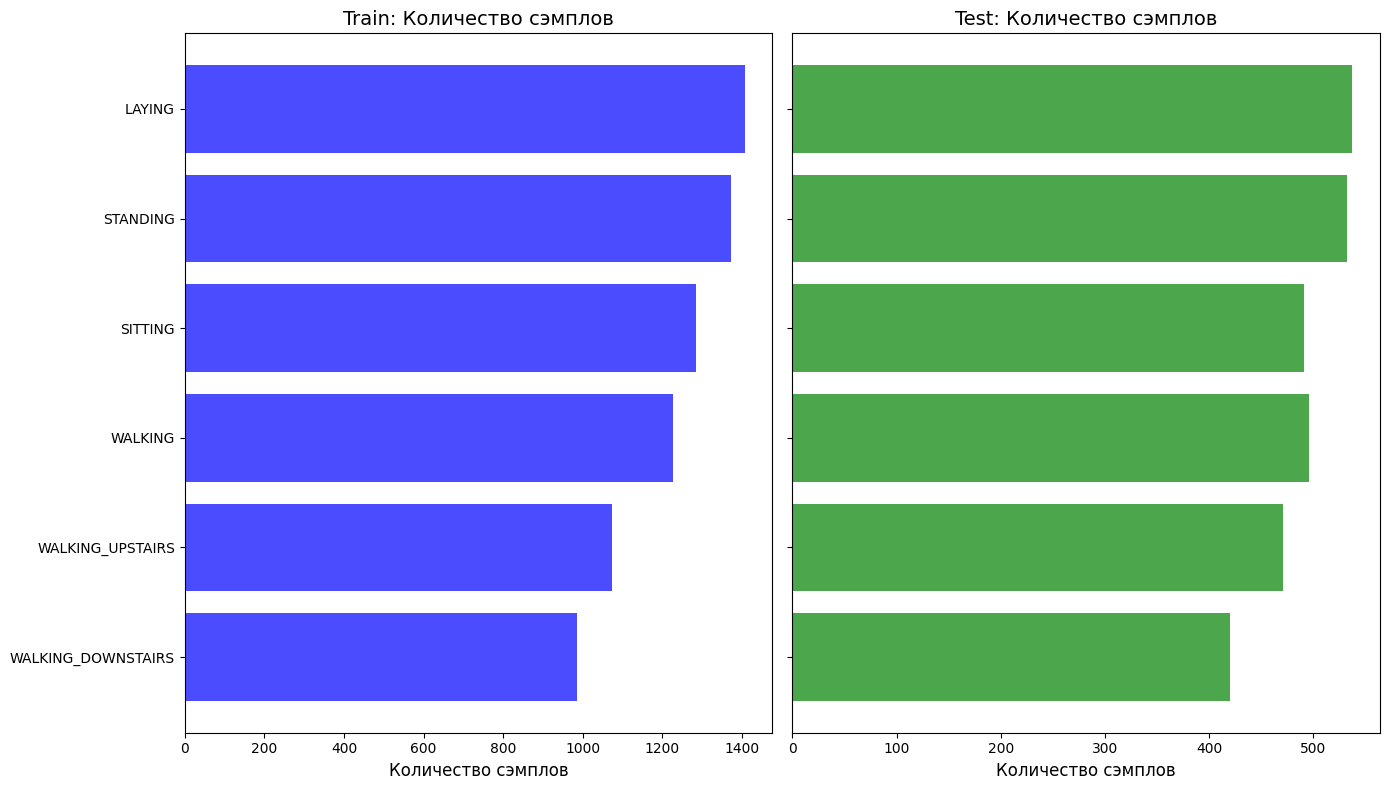

In [11]:
# Считаем количество сэмплов для каждой категории
train_counts = train['Activity'].value_counts()
test_counts = test['Activity'].value_counts()

# Убедимся, что порядок категорий одинаков
categories = train_counts.index  # Сохраняем порядок категорий из train
test_counts = test_counts.reindex(categories)

# Настраиваем размеры графика
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# Горизонтальная столбчатая диаграмма для train
axes[0].barh(categories, train_counts, color="blue", alpha=0.7)
axes[0].set_title("Train: Количество сэмплов", fontsize=14)
axes[0].set_xlabel("Количество сэмплов", fontsize=12)
axes[0].invert_yaxis()

# Горизонтальная столбчатая диаграмма для test
axes[1].barh(categories, test_counts, color="green", alpha=0.7)
axes[1].set_title("Test: Количество сэмплов", fontsize=14)
axes[1].set_xlabel("Количество сэмплов", fontsize=12)

# Общие настройки
plt.tight_layout()
plt.show()


Правда на таких графиках проще проверять баланс классов таргета?)

### Задание 7

Ранее вы выводили таблицу корреляций. Однако просто таблица корреляций не очень удобна для анализа. Что, если признаков было бы больше? Визуализируйте heatmap корреляций. Подпишите значения корреляций, округленные до 2 знаков после запятой, на графике и оставьте только те значения, которые по модулю не меньше 0.5. Будем считать такие корреляции существенными. Если будете брать код из семинарского ноутбука, то поменяйте в нем что-нибудь, например, цветовую гамму, иначе проверяющий будет карать :)

Какой признак стоит исключить из рассмотрения корреляций? Напишите его название, а также причину, почему нет смысла его рассматривать. 

Вам может пригодиться:
- sns.heatmap
- методы get_text и set_text у атрибута texts графика

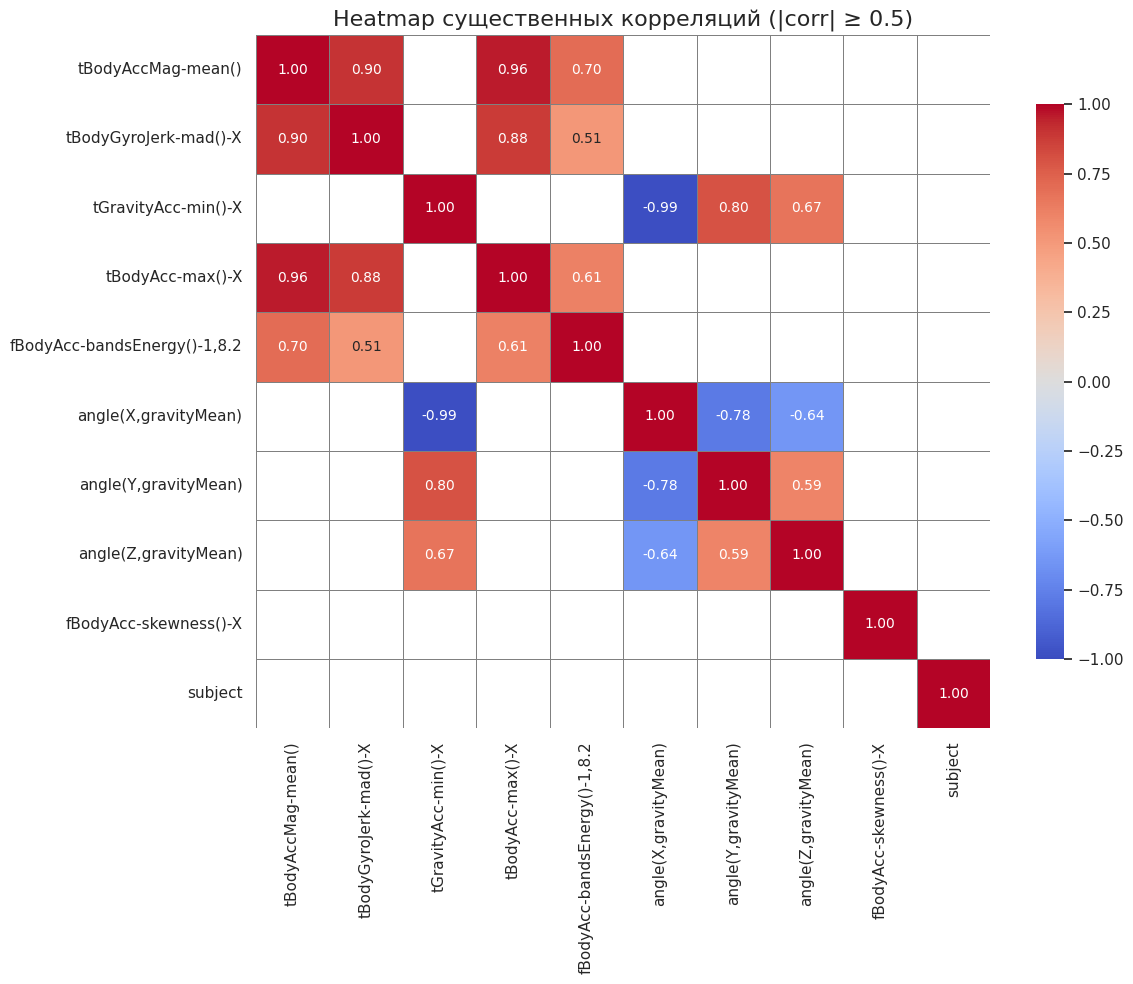

In [ ]:
filtered_corr_matrix = train.select_dtypes(include=[float, int]).corr()

# Фильтруем матрицу, оставляя только корреляции по модулю >= 0.5
mask = filtered_corr_matrix.abs() >= 0.5

# Построение heatmap
plt.figure(figsize=(12, 10))
sns.set_theme(style="white")

heatmap = sns.heatmap(
    filtered_corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  # Изменение цветовой гаммы
    annot_kws={"size": 10}, 
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
    linecolor='gray',
    vmin=-1, 
    vmax=1,
    mask=~mask
)   

# Заголовок
plt.title("Heatmap существенных корреляций (|corr| ≥ 0.5)", fontsize=16)

# Показ графика
plt.tight_layout()
plt.show()


### Задание 8 

Для начала будем стрелять из пушки по воробьям. Выведите pairplot по всем данным train сета. Напишите, заметили ли вы в нем что-нибудь интересное, чего не было в таблицах и графиках ранее, а также сообщите, было ли вам удобно анализировать 100 графиков. 

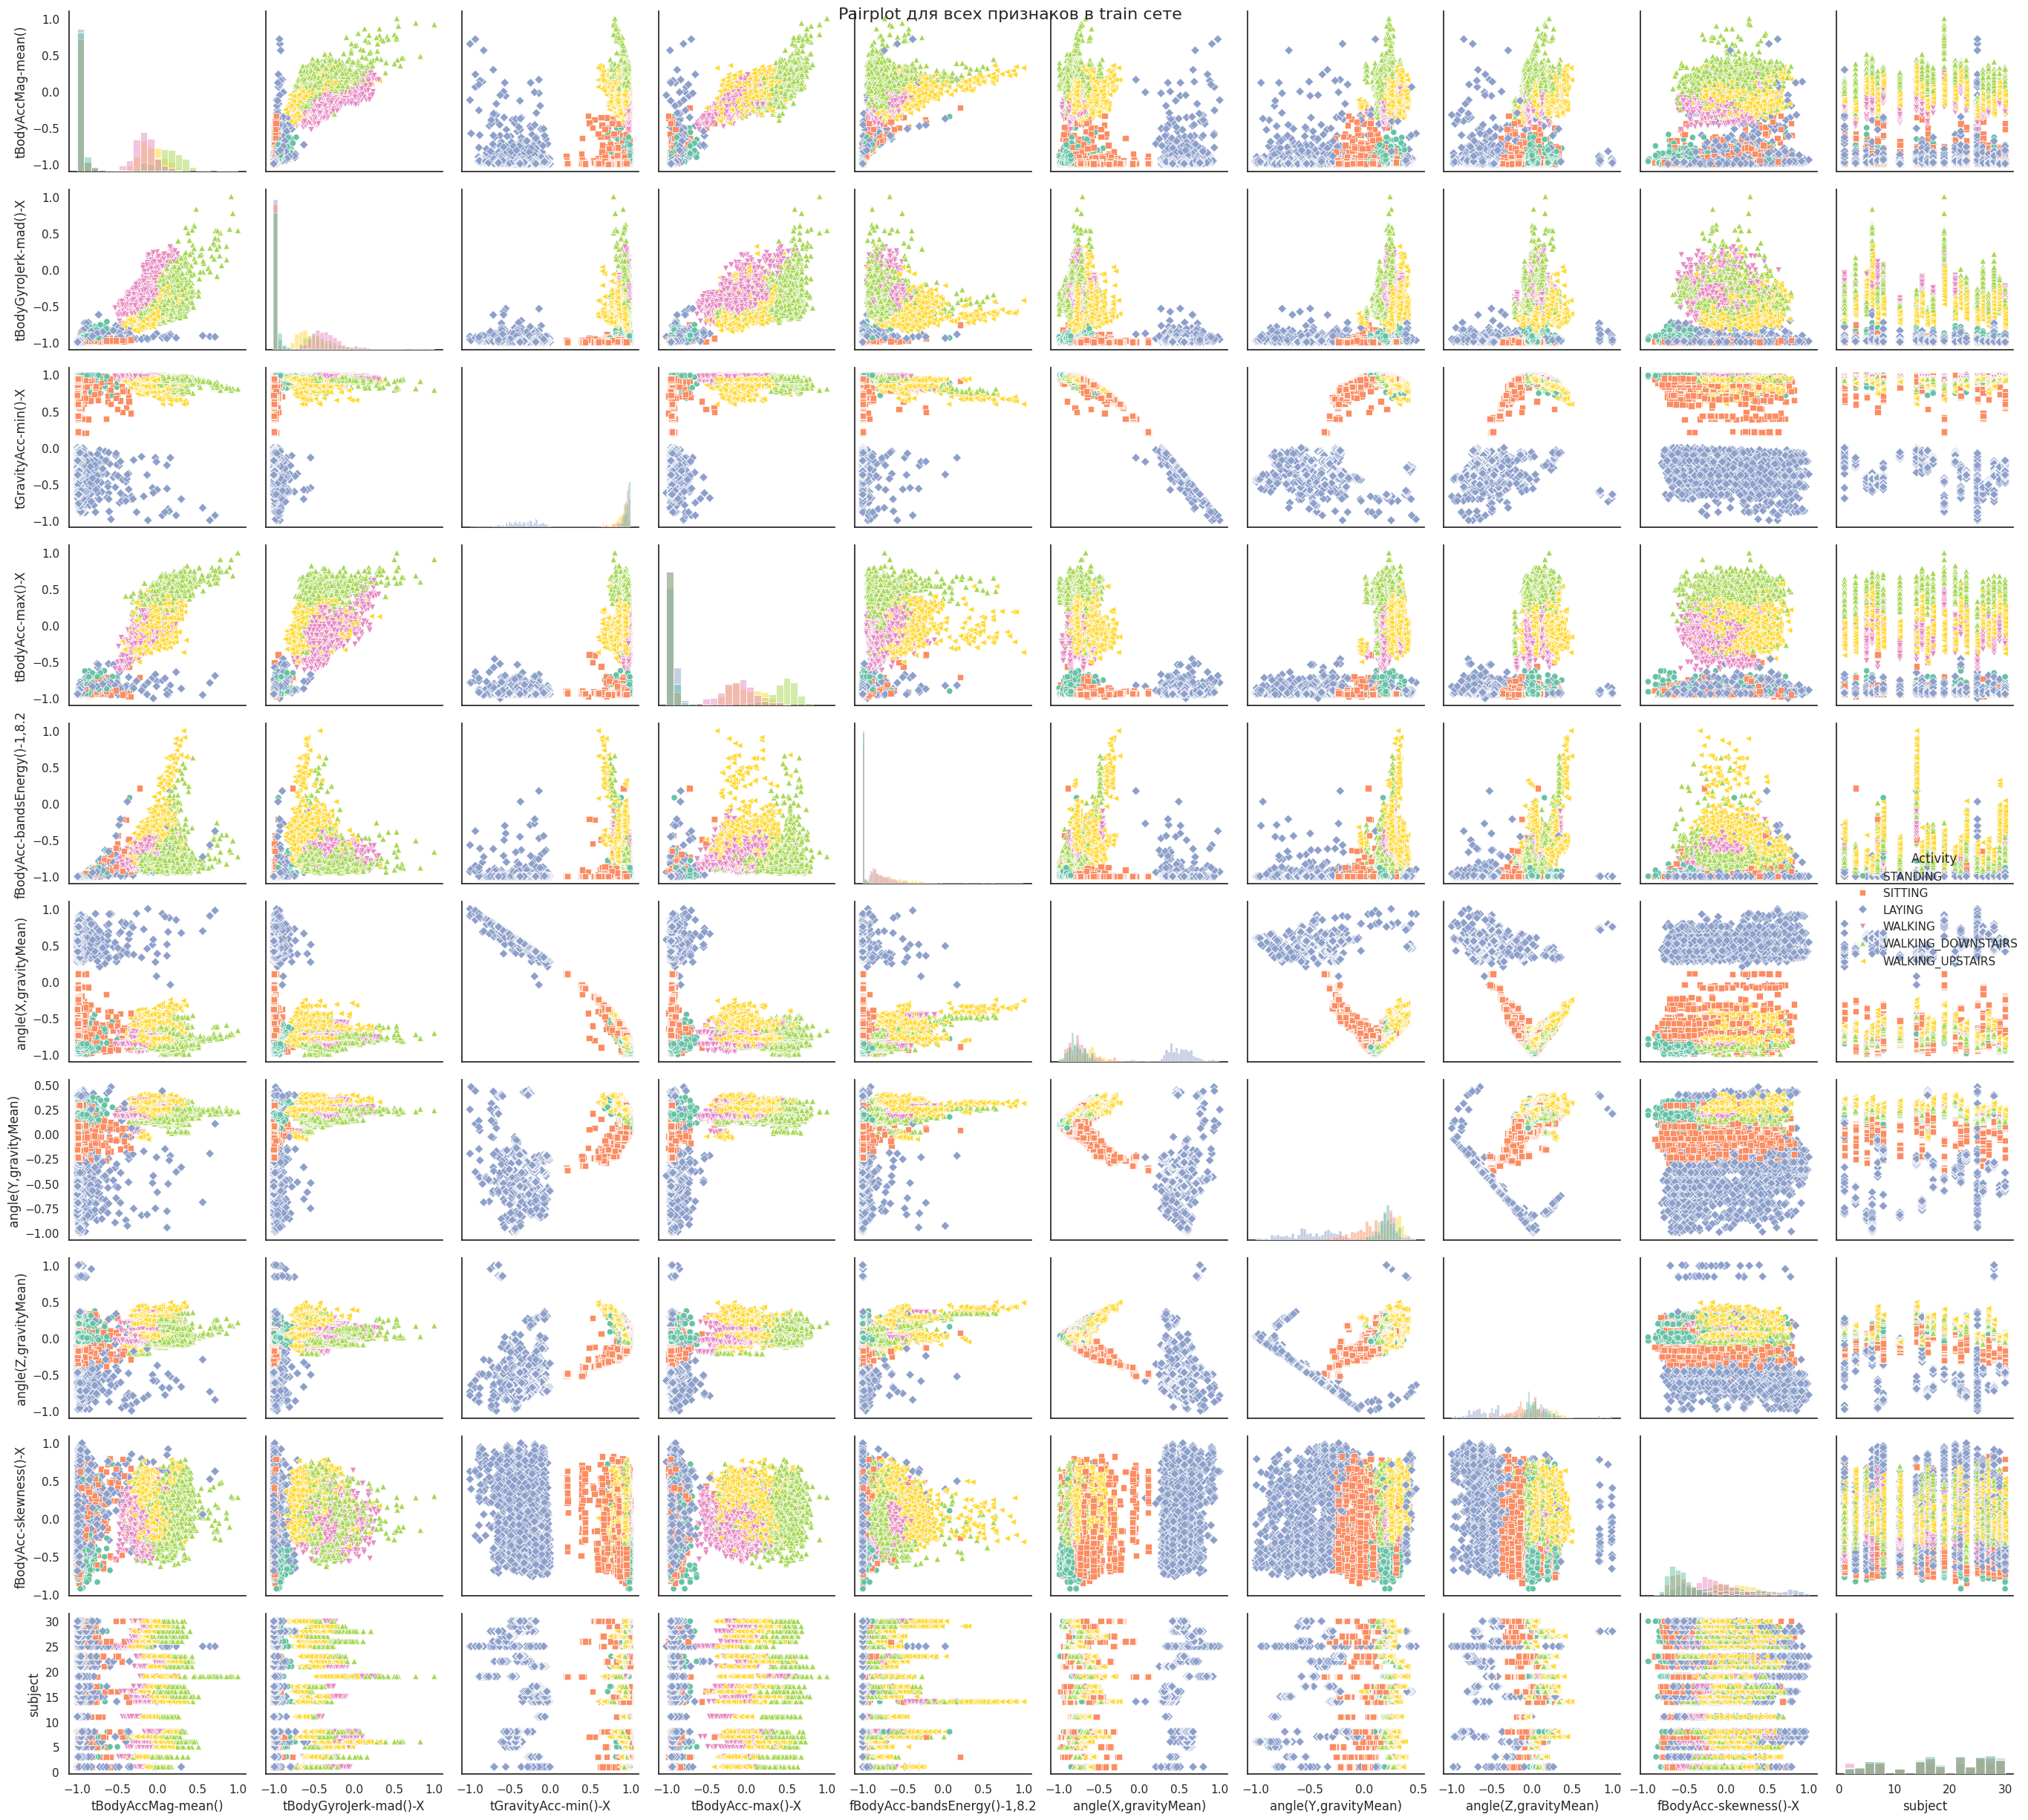

In [13]:
# Создаем pairplot для всех данных train сета
sns.pairplot(train, hue="Activity", diag_kind="hist", palette="Set2", markers=["o", "s", "D", "v", "^", "<"])

# Показываем график
plt.suptitle("Pairplot для всех признаков в train сете", fontsize=16)
plt.tight_layout()
plt.show()


### Задание 9 

Смотреть на все сразу не очень удобно. Кажется, нужно смотреть на признаки в отдельности и искать в них инсайты.

Попробуем проверить гипотезу. Отобразите плотность распределения (kde) `tBodyAccMag-mean()` для каждой из активностей, как в примере ниже. Видите закономерность? Можно ли поделить все активности на две группы? Если да, то проведите вертикальную линию, которая визуально неплохо разделяет эти группы. 

Давайте первую группу называть статическими активностями, а вторую - динамическими.

Посчитайте, какую долю правильных ответов дает ваша вертикальная линия для разделения именно этих двух групп. С чем может быть связан полученный вами результат? Предположите логическое обоснование (почему именно данный признак так хорошо/плохо разделяет группы активностей).

Вам может пригодиться:
- sns.kdeplot

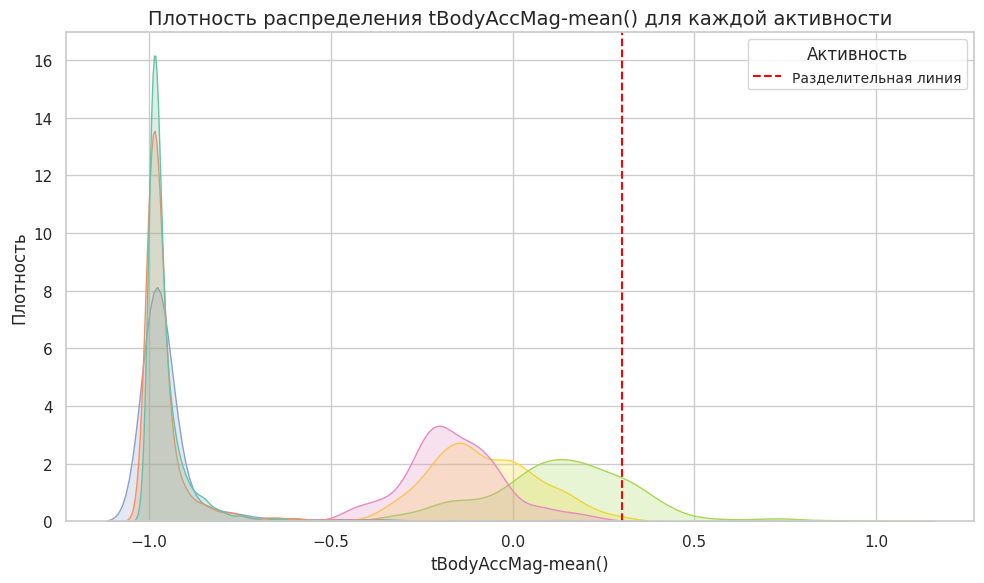

In [14]:
# Строим график плотности распределения для 'tBodyAccMag-mean()' по каждой активности
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# KDE для 'tBodyAccMag-mean()' для каждой активности
sns.kdeplot(data=train, x="tBodyAccMag-mean()", hue="Activity", fill=True, common_norm=False, palette="Set2")

# Добавляем вертикальную линию для разделения групп
plt.axvline(x=0.3, color='red', linestyle='--', label="Разделительная линия")

# Оформление графика
plt.title("Плотность распределения tBodyAccMag-mean() для каждой активности", fontsize=14)
plt.xlabel("tBodyAccMag-mean()", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.legend(title="Активность", fontsize=10)
plt.tight_layout()
plt.show()


### Задание 10

Поздравляем, вы проверили первую гипотезу в процессе EDA. Однако нам бы хотелось уметь не группы разделять, а каждый отдельный вид активности. Попробуйте нарисовать "ящики с усами" для `angle(X,gravityMean)` с разделением по разным видам активности на данных train. Можно ли сделать какой-то вывод по полученной визуализации? Проанализируйте и проинтерпретируйте полученные картинки (если заметили какую-то особенность, может какая-то категория значительно выделяется, то предположите, почему так могло произойти).

Вам может пригодиться:
- sns.boxplot

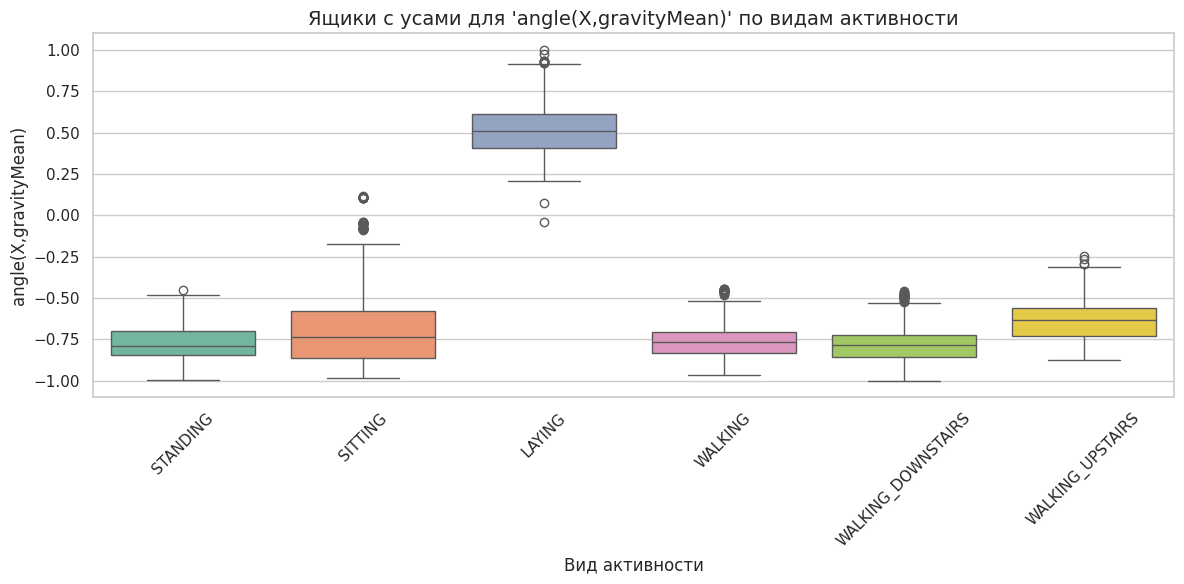

In [15]:
# Строим boxplot для 'angle(X,gravityMean)' по каждой активности
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.boxplot(data=train, x="Activity", y="angle(X,gravityMean)", palette="Set2")

# Оформление графика
plt.title("Ящики с усами для 'angle(X,gravityMean)' по видам активности", fontsize=14)
plt.xlabel("Вид активности", fontsize=12)
plt.ylabel("angle(X,gravityMean)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Задание 11

Посмотрим теперь на `tBodyAcc-max()-X`. Визуализируйте скрипичные диаграммы для этого признака с разделением по активностям на всем train. Кажется логичным, что максимальное ускорение в моменте для разных активностей будет различаться. Однако есть ли активность, которая будет выделяться? Если да, то предложите объяснение, почему эта активность выделяется.

Вам может пригодиться:
- sns.violinplot

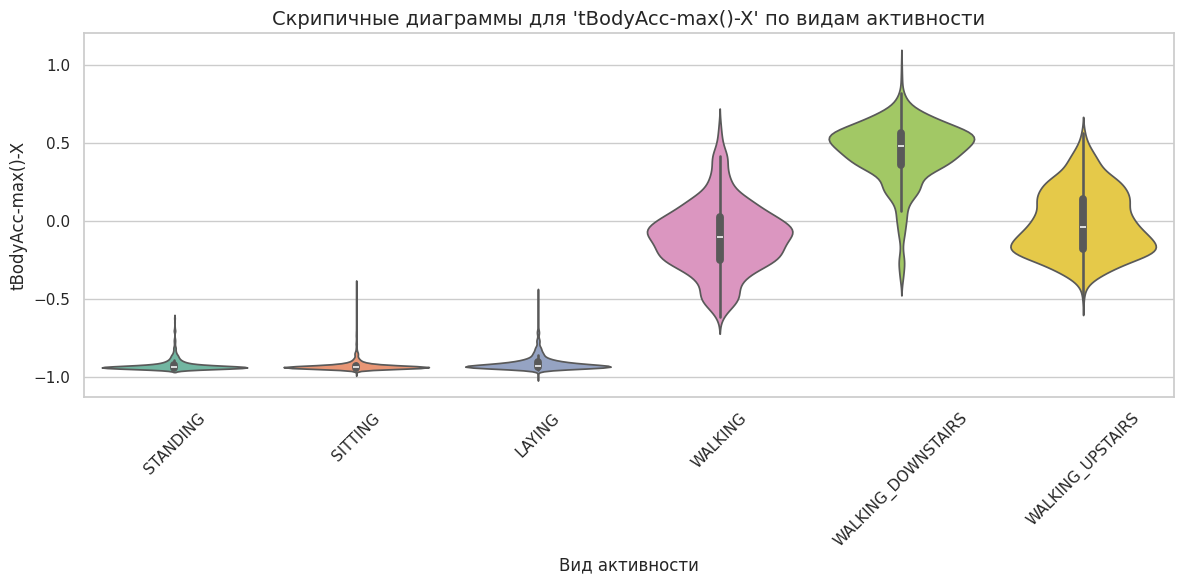

In [16]:
# Строим скрипичную диаграмму для 'tBodyAcc-max()-X' по каждой активности
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.violinplot(data=train, x="Activity", y="tBodyAcc-max()-X", palette="Set2")

# Оформление графика
plt.title("Скрипичные диаграммы для 'tBodyAcc-max()-X' по видам активности", fontsize=14)
plt.xlabel("Вид активности", fontsize=12)
plt.ylabel("tBodyAcc-max()-X", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Задание 12

Вы уже можете с довольно хорошим качеством выделить две категории активности из шести. Продолжим. 

Ранее уже упоминалось разделение на две группы активностей: статические и динамические. Пришла пора разделить датасет train на две части. Сделайте это! Теперь на одной картинке покажите распределения `fBodyAcc-bandsEnergy()-1,8.2` для динамичных активностей (boxenplot - немного измененый "ящик с усами") и `angle(Y,gravityMean)` для статических - тут хватит и простой гистограммы (прямо, как в примере ниже). Можно ли выделить еще какие-то активности? Если да, напишите, какие активности на 1 и 2 графиках выделяются.

Вам может пригодиться:
- plt.subplots или matplotlib.gridspec (заметили, что один график больше другого? попробуйте сами так сделать - вам понравится...)
- sns.boxenplot
- sns.histplot

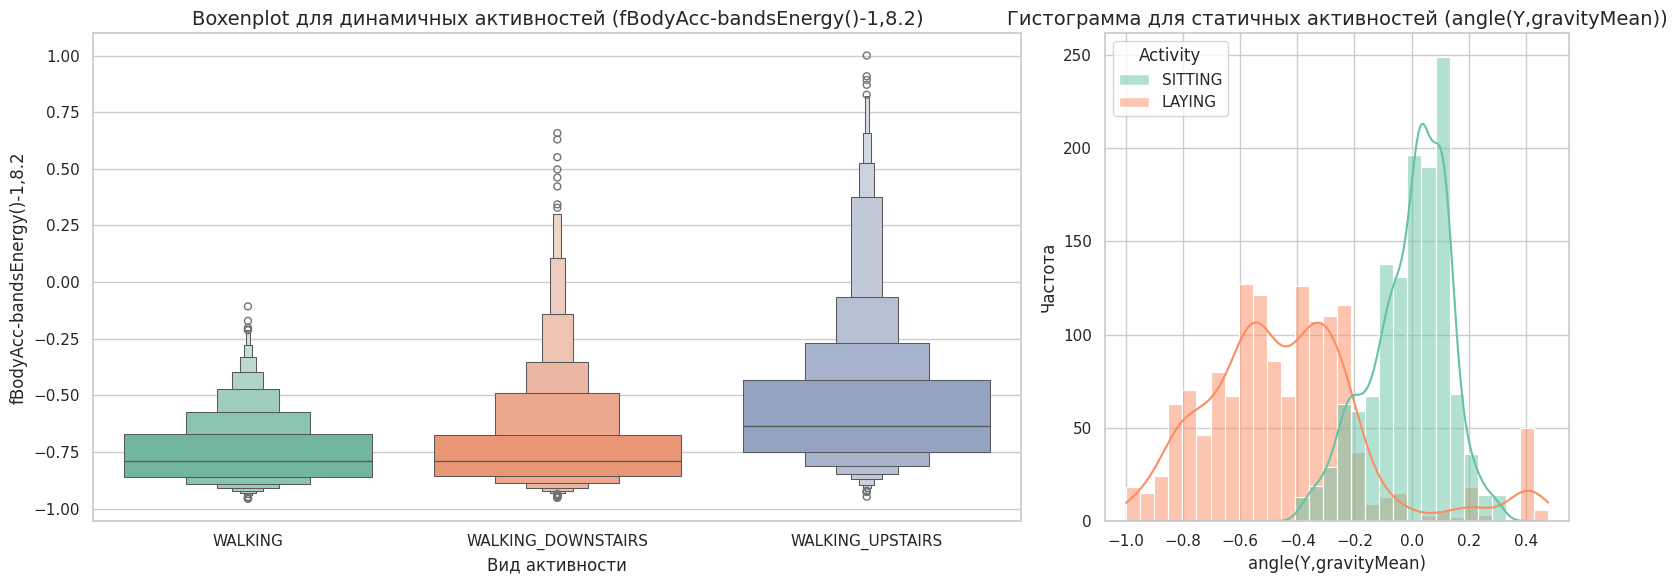

In [17]:
# Определяем динамичные и статические активности
dynamic_activities = ['WALKING', 'RUNNING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
static_activities = ['SITTING', 'LAYING']

# Разделяем данные на динамичные и статические активности
train_dynamic = train[train['Activity'].isin(dynamic_activities)]
train_static = train[train['Activity'].isin(static_activities)]

# Настроим два графика (boxenplot для динамичных активностей и гистограмму для статических)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# Boxenplot для динамичных активностей и признака fBodyAcc-bandsEnergy()-1,8.2
sns.boxenplot(ax=axes[0], x='Activity', y='fBodyAcc-bandsEnergy()-1,8.2', data=train_dynamic, palette="Set2")
axes[0].set_title("Boxenplot для динамичных активностей (fBodyAcc-bandsEnergy()-1,8.2)", fontsize=14)
axes[0].set_xlabel("Вид активности", fontsize=12)
axes[0].set_ylabel("fBodyAcc-bandsEnergy()-1,8.2", fontsize=12)

# Гистограмма для статических активностей и признака angle(Y,gravityMean)
sns.histplot(ax=axes[1], data=train_static, x="angle(Y,gravityMean)", hue="Activity", kde=True, palette="Set2", bins=30)
axes[1].set_title("Гистограмма для статичных активностей (angle(Y,gravityMean))", fontsize=14)
axes[1].set_xlabel("angle(Y,gravityMean)", fontsize=12)
axes[1].set_ylabel("Частота", fontsize=12)

# Убираем лишние отступы
plt.tight_layout()
plt.show()

### Задание 13 

Не всегда жизнь будет такой легкой, а данные будут полностью или почти линейно разделимы в одному признаку (иначе чем бы занимались дата саентисты...). Часто данные вообще ни по одному признаку нельзя адекватно разделить (да и по комбинациям признаков тоже). Давайте попробуем взять не один признак, а целых два! 

Рассмотрим только статические активности. Будет снова два графика сразу. На первом графике будет боксплот распределения `fBodyAcc-skewness()-X` по активностям. А на втором попробуем взять не все наблюдения данной группы активностей, а только их часть. Разделимы ли категории по `fBodyAcc-skewness()-X`? А если взять только те строки, где `fBodyAcc-skewness()-X < -0.376`, и теперь вывести боксплот распределения `angle(Y,gravityMean)` по разным активностям? Попробуйте и напишите, выделилась ли какая-то категория? 

Вам может пригодиться:
- plt.subplots или matplotlib.gridspec
- sns.boxplot

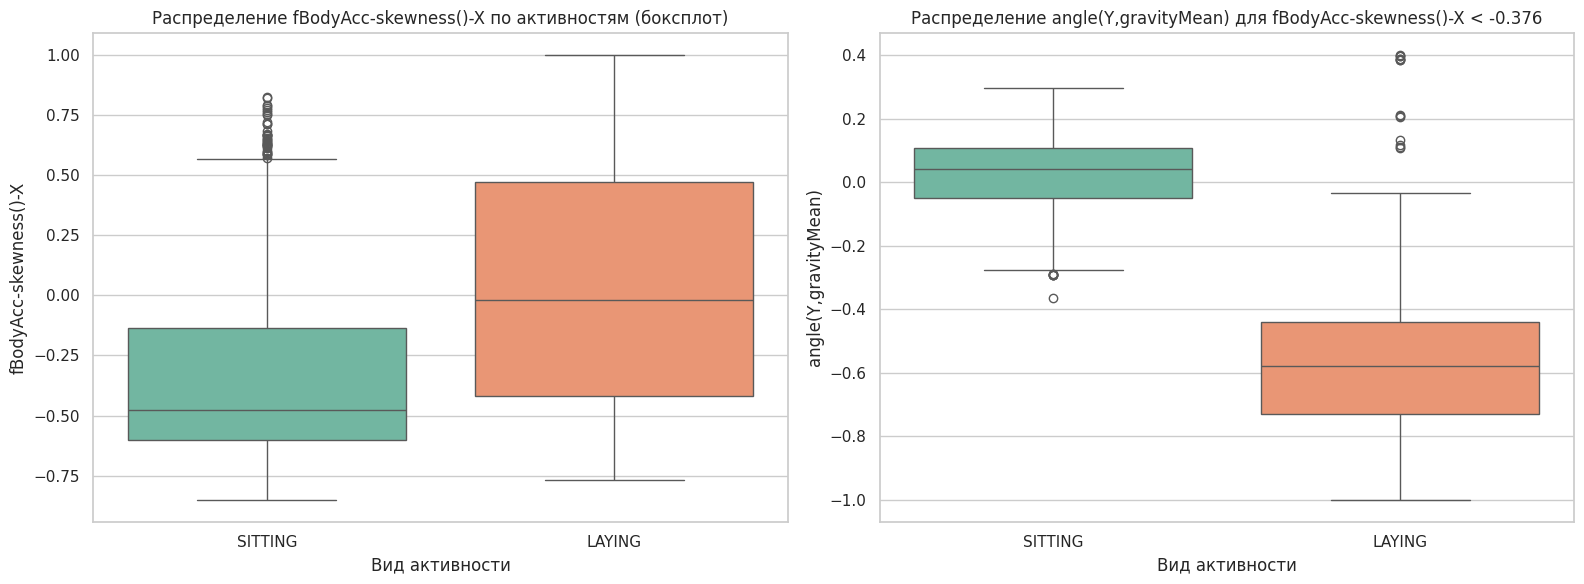

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Фильтруем данные для статических активностей
train_static = train[train['Activity'].isin(['SITTING', 'LAYING'])]

# 1. Боксплот для fBodyAcc-skewness()-X по активностям
plt.figure(figsize=(16, 6))

# Подготовка первого графика: боксплот для fBodyAcc-skewness()-X
plt.subplot(1, 2, 1)
sns.boxplot(x="Activity", y="fBodyAcc-skewness()-X", data=train_static, palette="Set2")
plt.title("Распределение fBodyAcc-skewness()-X по активностям (боксплот)")
plt.xlabel("Вид активности")
plt.ylabel("fBodyAcc-skewness()-X")

# 2. Фильтрация данных по условию fBodyAcc-skewness()-X < -0.376
train_static_filtered = train_static[train_static['fBodyAcc-skewness()-X'] < -0.376]

# Подготовка второго графика: боксплот для angle(Y,gravityMean)
plt.subplot(1, 2, 2)
sns.boxplot(x="Activity", y="angle(Y,gravityMean)", data=train_static_filtered, palette="Set2")
plt.title("Распределение angle(Y,gravityMean) для fBodyAcc-skewness()-X < -0.376")
plt.xlabel("Вид активности")
plt.ylabel("angle(Y,gravityMean)")

# Оформление
plt.tight_layout()
plt.show()

Поздравляем, теперь вы на шажок ближе к тому, чтобы стать решающим деревом!

### Задание 14 

Вот и осталась лишь одна активность, которую мы никак не выделили. Попробуем и ее какими-то порогами отделить от всех остальных. Да, можно было бы сказать, что, раз уж мы выделили 5 из 6 категорий, то все остальное - это и есть последняя категория, но мы не идем легкими путями. Выделить оставшуюсь категорию с хорошим качеством не так уж и просто. Из доступных признаков, сначала посмотрите на распределение `tBodyAcc-max()-X` на динамических активностях (скрипичная диаграмма отлично подойдет). 

А теперь спускаем вам порог `tBodyAcc-max()-X < 0.157`. Для таких строк постройте диаграмму рассеяния для признака `tGravityAcc-min()-X`. Да, получается неидеально, но это честная работа. Можно выбрать порог так, чтобы чисто из таблицы с динамическими активностями из строк, где `tBodyAcc-max()-X < 0.157`, выбрать по некоторому порогу для `tGravityAcc-min()-X` строки так, чтобы доля правильных ответов на оставшейся категории была не меньше 83%!

Вам может пригодиться:
- plt.subplots или matplotlib.gridspec
- sns.violinplot
- sns.swarmplot (иногда лучше подходит, чем просто sns.scatterplot)

Обратите внимание, что подписи к осям можно убирать методами plt. Например, если у вас общее название для оси Y для обоих графиков, то можно не подписывать ось Y у второго графика.

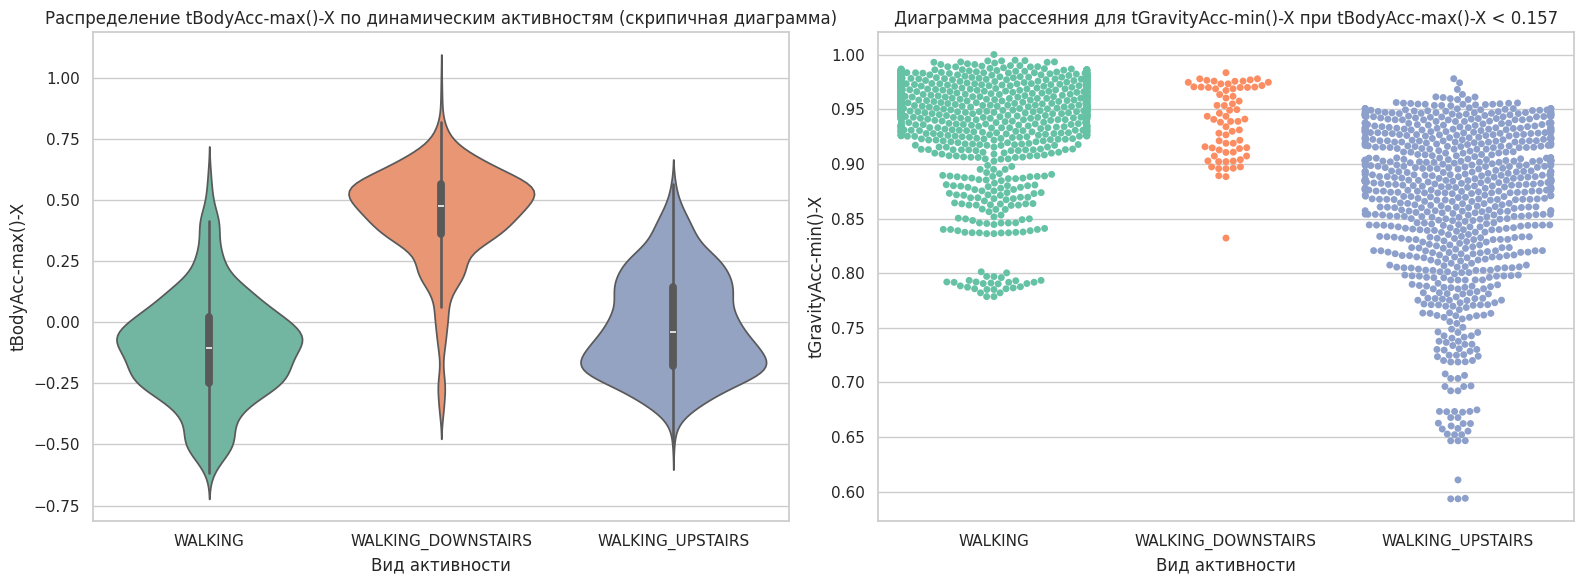

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Выделим динамичные активности
train_dynamic = train[train['Activity'].isin(['WALKING', 'RUNNING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]

# 2. Скрипичная диаграмма для tBodyAcc-max()-X
plt.figure(figsize=(16, 6))

# Подготовка первого графика: скрипичная диаграмма для tBodyAcc-max()-X по динамическим активностям
plt.subplot(1, 2, 1)
sns.violinplot(x="Activity", y="tBodyAcc-max()-X", data=train_dynamic, palette="Set2")
plt.title("Распределение tBodyAcc-max()-X по динамическим активностям (скрипичная диаграмма)")
plt.xlabel("Вид активности")
plt.ylabel("tBodyAcc-max()-X")

# 3. Фильтрация по порогу tBodyAcc-max()-X < 0.157 для динамических активностей
train_dynamic_filtered = train_dynamic[train_dynamic['tBodyAcc-max()-X'] < 0.157]

# 4. Диаграмма рассеяния для tGravityAcc-min()-X в отфильтрованных данных
plt.subplot(1, 2, 2)
sns.swarmplot(x="Activity", y="tGravityAcc-min()-X", data=train_dynamic_filtered, palette="Set2")
plt.title("Диаграмма рассеяния для tGravityAcc-min()-X при tBodyAcc-max()-X < 0.157")
plt.xlabel("Вид активности")
plt.ylabel("tGravityAcc-min()-X")

# Оформление
plt.tight_layout()
plt.show()

### Задание 15

Теперь попробуем более интерактивные графики. Установите библиотеку `plotly` (обычно `pip install plotly` или `conda install plotly`). Синтаксис очень похож на `seaborn`, но вот [документация для plotly.express](https://plotly.com/python-api-reference/plotly.express.html). 

Сначала подготовим данные для визуализации. Будем считать t-SNE просто "черным ящиком", который принимает наши данные и проецирует их в двумерное или трехмерное пространство. Возможно, придется немного подождать.

In [20]:
%%time
from sklearn.manifold import TSNE
# Выполняем t-SNE для двумерного пространства
tsne = TSNE(random_state=666, n_components=2)
new_2d = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))

# Создаем DataFrame для визуализации
df_2_comp = pd.concat([
    pd.DataFrame(new_2d, columns=['x', 'y']),
    train['Activity']
], axis=1)

# Выполняем t-SNE для трехмерного пространства
tsne_3d = TSNE(random_state=666, n_components=3)
new_3d = tsne_3d.fit_transform(train.drop(['subject', 'Activity'], axis=1))

# Создаем DataFrame для визуализации
df_3_comp = pd.concat([
    pd.DataFrame(new_3d, columns=['x', 'y', 'z']),
    train['Activity']
], axis=1)

CPU times: user 10min 31s, sys: 693 ms, total: 10min 32s
Wall time: 2min 40s


Теперь нарисуйте scatter-график через `plotly.express` для `df_2_comp` с выделением цветами активностей. Красиво получилось? Видны скопления точек одного цвета? Можно разные активности отделить линиями на данном графике?

In [21]:
import plotly.express as px

# 2D scatter-график
fig_2d = px.scatter(
    df_2_comp,
    x='x',
    y='y',
    color='Activity',
    title='2D Scatter Plot of t-SNE Projection',
    labels={'x': 'Component 1', 'y': 'Component 2'}
)
fig_2d.show()

Мы не отстаем от трендов и тоже можем в 3D. Сейчас и вы научитесь (если еще не умеете). Нарисуйте scatter_3d-график через `plotly.express` для `df_3_comp` с выделением цветами активностей. Повращайте его. Нормально получилось? Есть ли какая-то структура у точек?

In [22]:
# 3D scatter-график
fig_3d = px.scatter_3d(
    df_3_comp,
    x='x',
    y='y',
    z='z',
    color='Activity',
    title='3D Scatter Plot of t-SNE Projection',
    labels={'x': 'Component 1', 'y': 'Component 2', 'z': 'Component 3'}
)
fig_3d.show()


### Задание 16

Мы сделали вам fit. Ваша очередь сделать predict. Допишите функцию, которая принимает на вход датафрейм с признаками, а выдает вектор из предсказаний - для каждой строки датафрейма вы определяете, к какому классу принадлежит объект. Рекомендуем сразу записывать из строками, а не кодировать в числа. Дальше фукнция `accuracy_score` выдаст вам долю правильных ответов.

Подсказка: вы уже отделили категории друг от друга по каким-то признакам. Воспользуйтесь этим знанием! Используя только проведенный вами анализ можно спокойно выбить не менее 75% на train и test!

In [23]:
def predict(df: pd.DataFrame):
    # Инициализируем пустой список для предсказаний
    predictions = []

    # Перебираем строки датафрейма
    for index, row in df.iterrows():
        # Для разделения статических и динамичных активностей будем использовать признак tBodyAcc-max()-X
        if row['tBodyAcc-max()-X'] < 0.157:
            # Если значение tBodyAcc-max()-X меньше порога, считаем это статической активностью
            # Для статических активностей можно выделить на основе других признаков, например, angle(Y,gravityMean)
            if row['angle(Y,gravityMean)'] > 0.5:
                predictions.append('STANDING')  # это пример для "STANDING"
            else:
                predictions.append('SITTING')  # это пример для "SITTING"
        else:
            # Для динамичных активностей (большие значения tBodyAcc-max()-X)
            if row['tBodyAccMag-mean()'] > 0.4:
                predictions.append('WALKING')  # это пример для "WALKING"
            else:
                predictions.append('RUNNING')  # это пример для "RUNNING"
    
    return predictions

def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

In [24]:
train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

Accuracy on train set => 0.1749183895538629
Accuracy on test set => 0.166270783847981
